# Import unwrap

In [ ]:
import sys
!{sys.executable} -m pip uninstall -y unwrap
!{sys.executable} -m pip install --no-deps -U --no-cache git+https://github.com/jgraving/unwrap
!{sys.executable} -m pip install seaborn
# !{sys.executable} -m pip install fastprogress
# !{sys.executable} -m pip install nutpie

Found existing installation: unwrap 0.0.1
Uninstalling unwrap-0.0.1:
  Successfully uninstalled unwrap-0.0.1
Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/jgraving/unwrap to c:\users\james foster\appdata\local\temp\pip-req-build-33_x1m04
  Resolved https://github.com/jgraving/unwrap to commit 48e371b3a1a5af14f3f2e8fd0abe0b5c451be9bd
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for unwrap: filename=unwrap-0.0.1-py3-none-any.whl size=13551 sha256=f0d1e7b538890378f1fd4facac96f86595aa64e627c5e3c085f723367bb3972d
  Stored in directory: C:\Users\James Foster\AppData\Local\Temp\pip-ephem-wheel-cache-f1lvwpbq\wheels\6d\a6\84\e3cfe169b27e40b37f18ed01b9a2ce83462e4b2ccd53a02794
Successfully built unwrap


  Running command git clone --filter=blob:none --quiet https://github.com/jgraving/unwrap 'C:\Users\James Foster\AppData\Local\Temp\pip-req-build-33_x1m04'


Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


# Read in data

In [2]:
import pandas as pd
import numpy as np
from unwrap.link.numpy import shifted_modulo

# Load the file
file_path = 'SecurityLightBergsig.txt'
df = pd.read_csv(file_path, sep='\t')

# Create a binary indicator for the Light (1 for 'ON', 0 for 'OFF')
df['Light'] = df['Experiment'].apply(lambda x: 1 if 'ON' in x else 0)

# Convert the 'Heading' column from degrees to radians
df['Heading'] = pd.to_numeric(df['Heading'], errors='coerce')  # Convert non-numeric values (e.g., 'NA') to NaN
df['HeadingRadians'] = np.deg2rad(df['Heading'])

# Normalize the heading radians to be between -pi and pi
df['HeadingRadians'] = df['HeadingRadians'].apply(lambda x: shifted_modulo(x) if pd.notnull(x) else x)

# Keep only the relevant columns and drop rows with missing values
df = df[['Light', 'Beetle', 'Trial', 'HeadingRadians']].dropna().copy()
df.reset_index(drop=True, inplace=True)

# Rename columns: change 'Beetle' to 'Individual'
df = df.rename(columns={'Beetle': 'Individual'})
df['Individual'] = df['Individual'].astype('category')

df.head()


Light Individual  Trial  HeadingRadians
0      1          1      1        2.617994
1      1          1      2       -2.792527
2      1          1      3       -2.792527
3      1          1      4       -2.617994
4      1          1      5       -2.617994

# Plot data

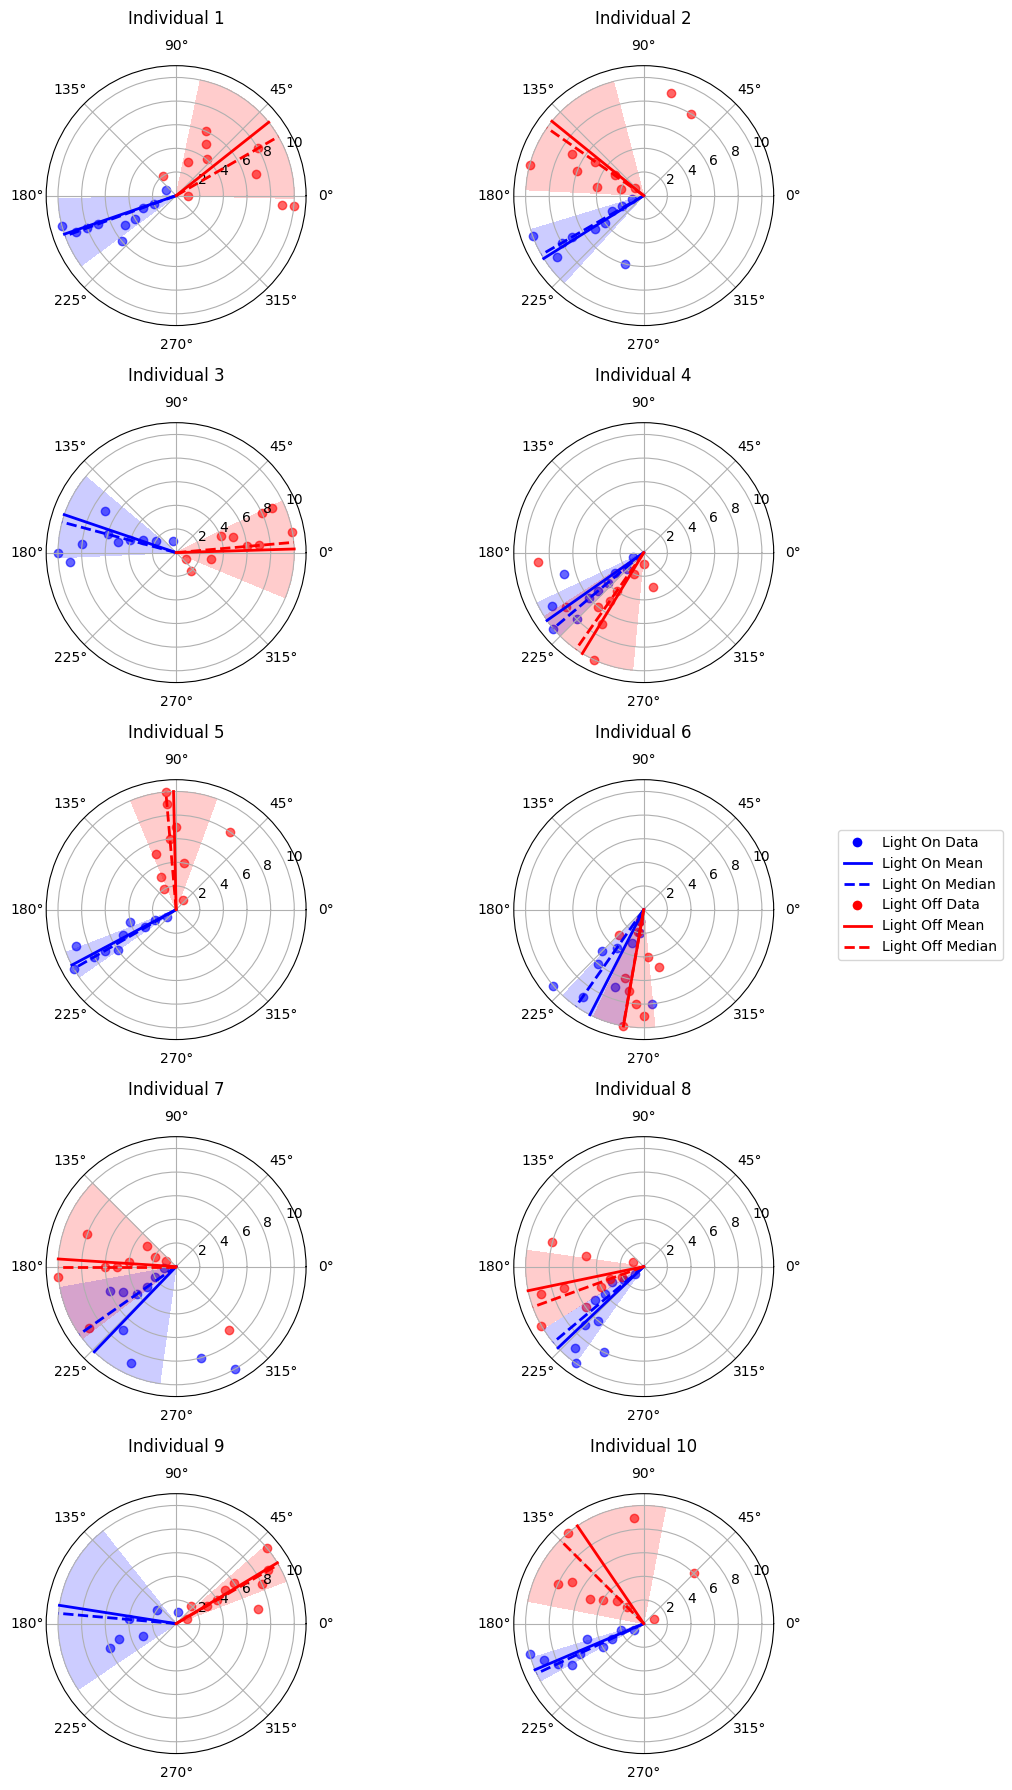

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import circmean, circstd
from matplotlib.lines import Line2D

# Helper function to compute the circular median.
def circ_median(angles):
    angles = np.sort(angles)
    diffs = np.abs(np.angle(np.exp(1j * (angles[:, None] - angles[None, :]))))
    sum_diffs = np.sum(diffs, axis=1)
    return angles[np.argmin(sum_diffs)]

# Helper function to scatter-plot data for one condition.
def plot_scatter(ax, data, angle_col, radial_col, color, label):
    if not data.empty:
        ax.scatter(data[angle_col], data[radial_col],
                   color=color, alpha=0.6, label=label)

# Helper function to compute and plot summary statistics.
# It plots a solid vertical line at the circular mean and a dashed vertical line at the circular median,
# both in the specified color. It also fills the region ± the circular standard deviation.
def plot_summary_stats(ax, angles, radial_max, color):
    # Compute circular mean, median, and standard deviation.
    mean_val = circmean(angles, high=np.pi, low=-np.pi)
    median_val = circ_median(angles)
    std_val = circstd(angles, high=np.pi, low=-np.pi, normalize=True)
    
    # Plot mean (solid) and median (dashed).
    ax.plot([mean_val, mean_val], [0, radial_max], color=color, linewidth=2)
    ax.plot([median_val, median_val], [0, radial_max], color=color, linewidth=2, linestyle='--')
    
    # Fill the region between mean minus std and mean plus std.
    theta_vals = np.linspace(mean_val - std_val, mean_val + std_val, 100)
    r_vals = np.linspace(0, radial_max, 100)
    Theta, R = np.meshgrid(theta_vals, r_vals)
    ax.contourf(Theta, R, np.ones_like(Theta), alpha=0.2, colors=[color])
    
    return mean_val, median_val, std_val

# Get unique individual IDs.
unique_individuals = df['Individual'].unique()

# Create a grid of polar subplots.
n_plots = len(unique_individuals)
n_rows, n_cols = 5, 2  # Adjust grid dimensions as needed.
fig, axes = plt.subplots(n_rows, n_cols, subplot_kw={'projection': 'polar'}, figsize=(10, 18))
axes = axes.flatten()

radial_max = 10  # Maximum radial value

# Plot for each individual.
for idx, individual in enumerate(unique_individuals):
    ax = axes[idx]
    individual_data = df[df['Individual'] == individual]
    
    # Separate Light On and Light Off data (drop NaNs in HeadingRadians).
    data_on = individual_data[individual_data['Light'] == 1].dropna(subset=['HeadingRadians'])
    data_off = individual_data[individual_data['Light'] == 0].dropna(subset=['HeadingRadians'])
    
    # Scatter-plot data.
    plot_scatter(ax, data_on, 'HeadingRadians', 'Trial', 'blue', 'Light On')
    plot_scatter(ax, data_off, 'HeadingRadians', 'Trial', 'red', 'Light Off')
    
    # Plot summary statistics for each condition.
    if not data_on.empty:
        plot_summary_stats(ax, data_on['HeadingRadians'].values, radial_max, 'blue')
    if not data_off.empty:
        plot_summary_stats(ax, data_off['HeadingRadians'].values, radial_max, 'red')
    
    ax.set_title(f'Individual {individual}', pad=30)
    ax.set_ylim(0, radial_max + 1)
    # Remove individual legends from each subplot.
    ax.legend().set_visible(False)

# Create a shared custom legend.
legend_handles = [
    # For Light On (blue)
    Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=8, label='Light On Data'),
    Line2D([0], [0], color='blue', lw=2, label='Light On Mean'),
    Line2D([0], [0], color='blue', lw=2, linestyle='--', label='Light On Median'),
    # For Light Off (red)
    Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=8, label='Light Off Data'),
    Line2D([0], [0], color='red', lw=2, label='Light Off Mean'),
    Line2D([0], [0], color='red', lw=2, linestyle='--', label='Light Off Median'),
]

# Add one shared legend to the right of the figure.
fig.legend(handles=legend_handles, loc='center right', bbox_to_anchor=(1.10, 0.5), fontsize='medium')

plt.tight_layout()
plt.show()


# Initial model

In [4]:
# from fastprogress import fastprogress
# fastprogress.printing = lambda: True

import numpy as np
import pandas as pd
import bambi as bmb
import arviz as az
import matplotlib.pyplot as plt

from unwrap.link.bambi import LINKS
from unwrap.link.numpy import inverse_softplus
from unwrap.prior import CircularUniformPrior

# Define the model formula with updated, capitalized variable names.
formula = bmb.Formula(
    "HeadingRadians ~ Light + (1 + Light|Individual)",
    "kappa ~ Light + (1 + Light|Individual)",
)

# Specify priors for the model with capitalized keys and updated variable names.
priors = {
    # Fixed effects for μ:
    "Intercept": CircularUniformPrior(),
    "Light": bmb.Prior("Normal", mu=0, sigma=0.1 * np.pi),
    # Individual-level effects for μ:
    "1|Individual": bmb.Prior(
        "VonMises", mu=0, kappa=bmb.Prior("LogNormal", mu=np.log(5), sigma=0.1)
    ),
    "Light|Individual": bmb.Prior(
        "Normal", mu=0, sigma=bmb.Prior("LogNormal", mu=np.log(0.25), sigma=0.1)
    ),
    # Priors for the κ-model (inside the "kappa" dictionary):
    "kappa": {
        # Fixed effects for κ:
        "Intercept": bmb.Prior("Normal", mu=inverse_softplus(2), sigma=1),
        "Light": bmb.Prior("Normal", mu=0, sigma=2.5),
        # Individual-level effects for κ:
        "1|Individual": bmb.Prior(
            "Normal", mu=0, sigma=bmb.Prior("LogNormal", mu=np.log(0.5), sigma=0.1)
        ),
        "Light|Individual": bmb.Prior(
            "Normal", mu=0, sigma=bmb.Prior("LogNormal", mu=np.log(0.5), sigma=0.1)
        ),
    },
}

# Build the model using the updated formula and priors.
model_tight = bmb.Model(
    formula,
    df,
    family="vonmises",
    priors=priors,
    link={"mu": LINKS["shifted_modulo"], "kappa": LINKS["softplus"]},
    center_predictors=False,
    dropna=True,
)

print(model_tight)

# Fit the model.
idata_tight = model_tight.fit(draws=1000, idata_kwargs={"log_likelihood": True})


       Formula: HeadingRadians ~ Light + (1 + Light|Individual)
                kappa ~ Light + (1 + Light|Individual)
        Family: vonmises
          Link: mu = shifted_modulo
                kappa = softplus
  Observations: 196
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ CircularUniform()
            Light ~ Normal(mu: 0.0, sigma: 0.3142)
        
        Group-level effects
            1|Individual ~ VonMises(mu: 0.0, kappa: LogNormal(mu: 1.6094, sigma: 0.1))
            Light|Individual ~ Normal(mu: 0.0, sigma: LogNormal(mu: -1.3863, sigma: 0.1))
    target = kappa
        Common-level effects
            kappa_Intercept ~ Normal(mu: 1.8546, sigma: 1.0)
            kappa_Light ~ Normal(mu: 0.0, sigma: 2.5)
        
        Group-level effects
            kappa_1|Individual ~ Normal(mu: 0.0, sigma: LogNormal(mu: -0.6931, sigma: 0.1))
            kappa_Light|Individual ~ Normal(mu: 0.0, sigma: LogNormal(mu: -0.6931, sigma: 0.1))


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, Light, 1|Individual_kappa, 1|Individual, Light|Individual_sigma, Light|Individual_offset, kappa_Intercept, kappa_Light, kappa_1|Individual_sigma, kappa_1|Individual_offset, kappa_Light|Individual_sigma, kappa_Light|Individual_offset]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 61 seconds.


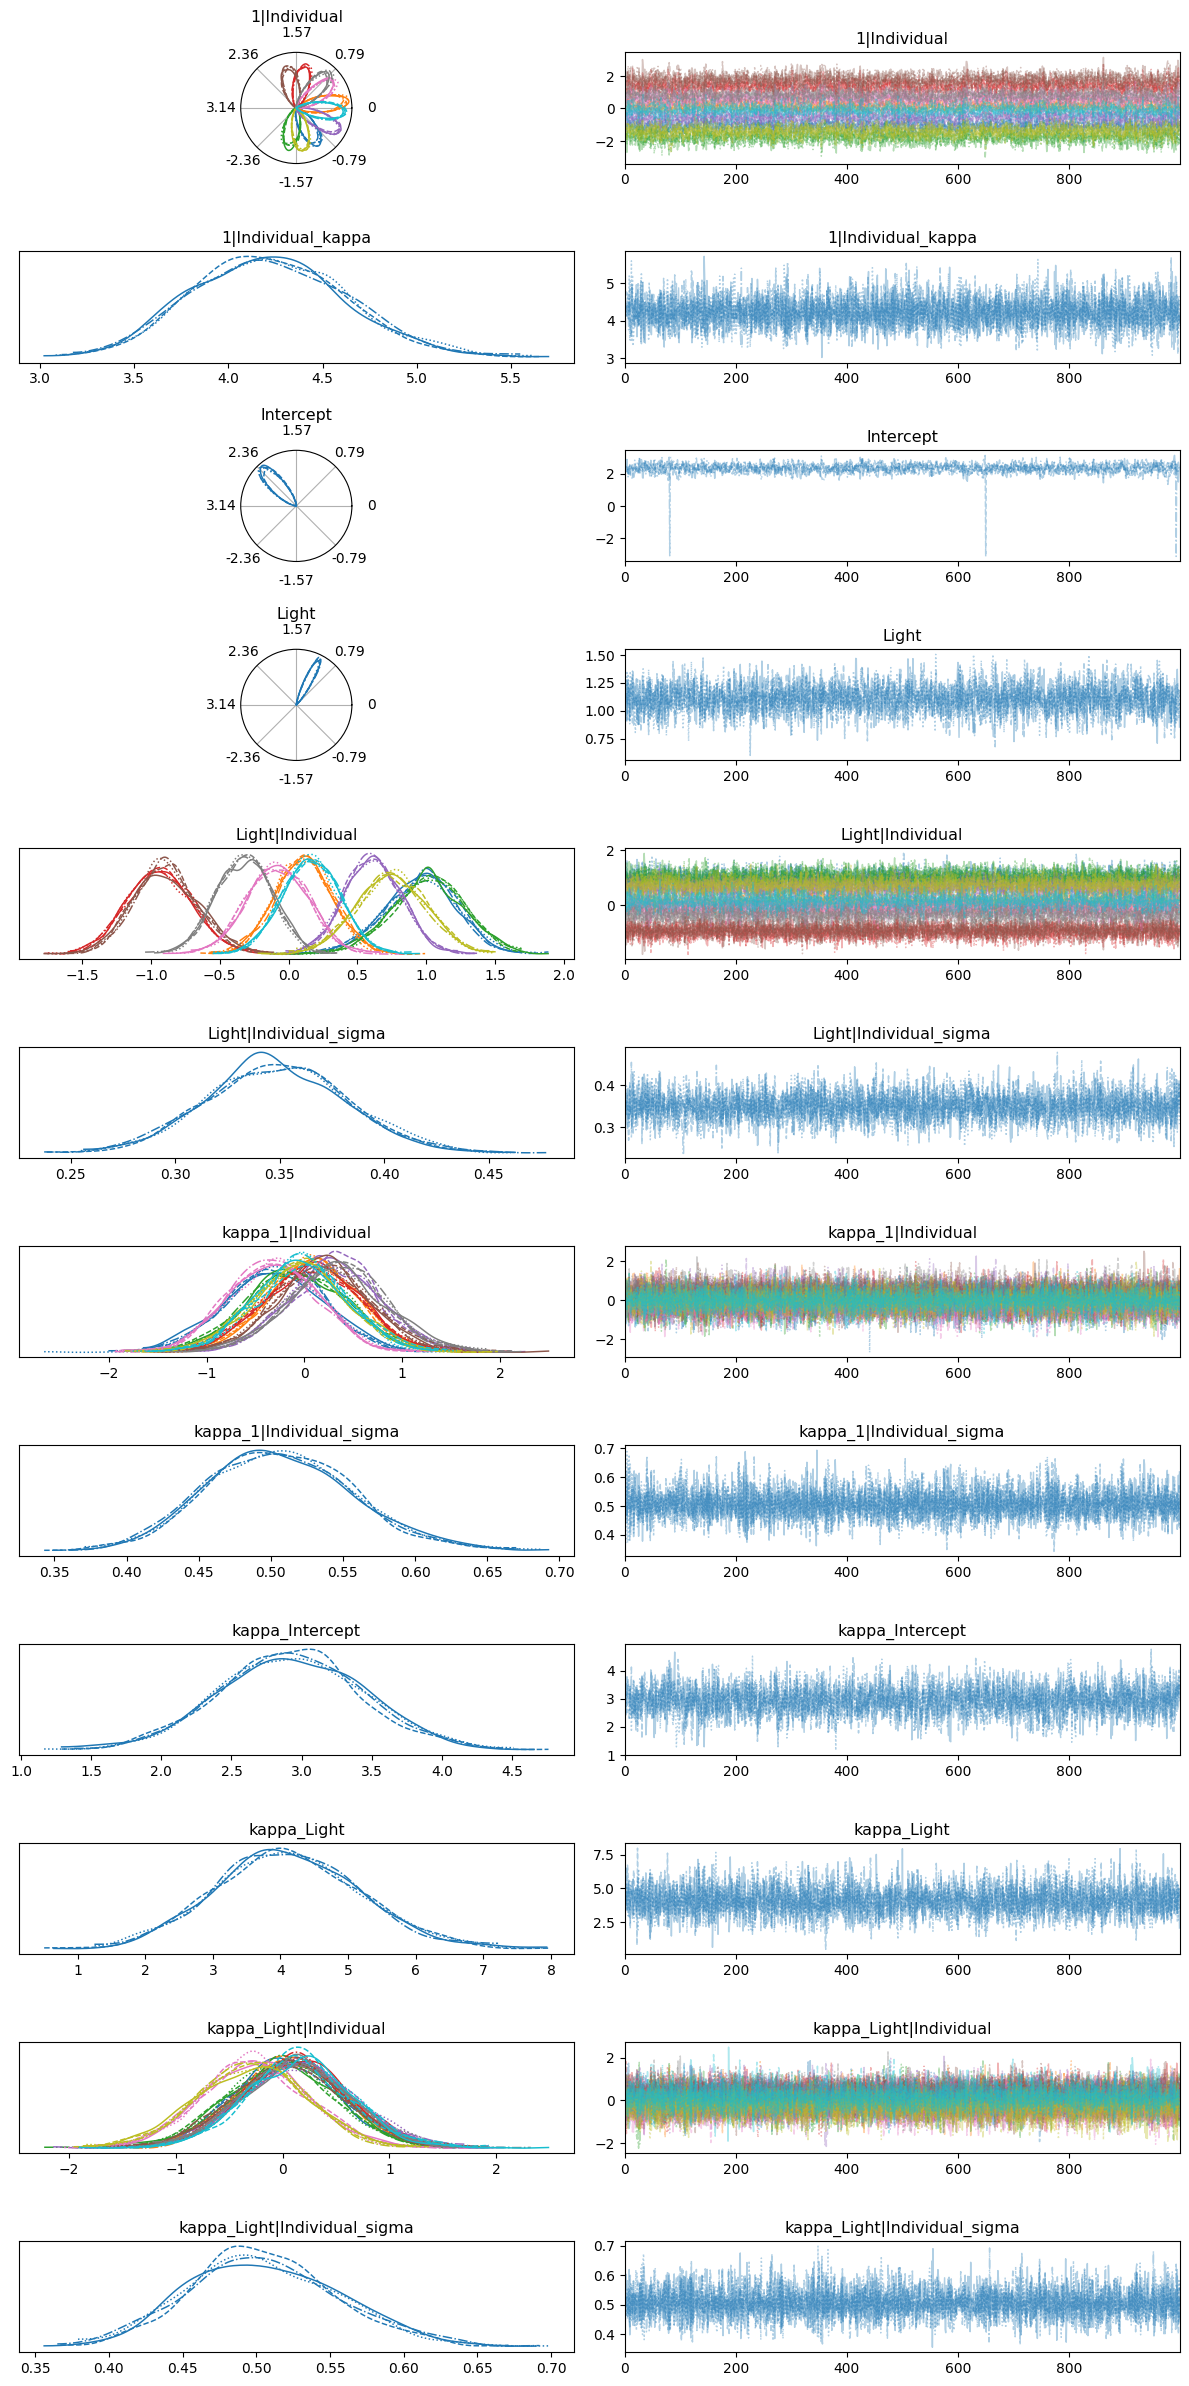

In [5]:
az.plot_trace(idata_tight, circ_var_names=["Light", "Intercept", "1|Individual"])
plt.tight_layout()
plt.show()

In [6]:
az.summary(
    idata_tight, 
    var_names=["Intercept", "Light", "kappa_Intercept", "kappa_Light"],
    circ_var_names=["Intercept", "Light"]
)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
Intercept        2.327  0.250   1.867    2.810      0.008    0.006    1379.0   
Light            1.106  0.126   0.861    1.336      0.001    0.002    3174.0   
kappa_Intercept  2.924  0.513   2.000    3.945      0.009    0.006    3158.0   
kappa_Light      4.118  1.071   2.106    6.131      0.014    0.011    5633.0   

                 ess_tail  r_hat  
Intercept          1628.0    1.0  
Light              3040.0    1.0  
kappa_Intercept    2649.0    1.0  
kappa_Light        2925.0    1.0

In [7]:
az.summary(
    idata_tight, 
    circ_var_names=["Intercept", "Light", "1|Individual"]
)

mean     sd  hdi_3%  hdi_97%  mcse_mean  \
1|Individual[1]              -1.044  0.326  -1.713   -0.475      0.006   
1|Individual[2]               0.148  0.273  -0.364    0.653      0.007   
1|Individual[3]              -1.767  0.347  -2.419   -1.111      0.008   
1|Individual[4]               1.368  0.323   0.762    1.975      0.009   
1|Individual[5]              -0.485  0.278  -1.006    0.046      0.006   
1|Individual[6]               1.806  0.328   1.221    2.436      0.008   
1|Individual[7]               0.607  0.291   0.064    1.151      0.009   
1|Individual[8]               0.829  0.281   0.255    1.305      0.007   
1|Individual[9]              -1.402  0.311  -2.014   -0.851      0.008   
1|Individual[10]             -0.079  0.279  -0.605    0.443      0.007   
1|Individual_kappa            4.220  0.405   3.527    5.029      0.005   
Intercept                     2.327  0.250   1.867    2.810      0.008   
Light                         1.106  0.126   0.861    1.336      0.001   
Light|Individual[1]           0.957  0.267   0.419    1.417      0.004   
Light|Individual[2]           0.108  0.208  -0.259    0.526      0.003   
Light|Individual[3]           1.015  0.267   0.503    1.497      0.004   
Light|Individual[4]          -0.936  0.238  -1.373   -0.476      0.004   
Light|Individual[5]           0.611  0.210   0.219    0.998      0.003   
Light|Individual[6]          -0.892  0.234  -1.340   -0.462      0.004   
Light|Individual[7]          -0.079  0.225  -0.488    0.347      0.003   
Light|Individual[8]          -0.323  0.202  -0.683    0.059      0.003   
Light|Individual[9]           0.745  0.253   0.268    1.212      0.003   
Light|Individual[10]          0.164  0.209  -0.236    0.544      0.003   
Light|Individual_sigma        0.349  0.033   0.288    0.413      0.001   
kappa_1|Individual[1]        -0.302  0.500  -1.209    0.665      0.006   
kappa_1|Individual[2]         0.091  0.465  -0.797    0.953      0.005   
kappa_1|Individual[3]        -0.072  0.520  -1.080    0.876      0.006   
kappa_1|Individual[4]         0.078  0.498  -0.871    0.964      0.006   
kappa_1|Individual[5]         0.311  0.480  -0.610    1.187      0.005   
kappa_1|Individual[6]         0.194  0.496  -0.765    1.111      0.006   
kappa_1|Individual[7]        -0.317  0.460  -1.133    0.532      0.005   
kappa_1|Individual[8]         0.335  0.496  -0.643    1.242      0.005   
kappa_1|Individual[9]        -0.041  0.487  -0.947    0.878      0.005   
kappa_1|Individual[10]       -0.029  0.468  -0.861    0.863      0.005   
kappa_1|Individual_sigma      0.507  0.051   0.408    0.600      0.001   
kappa_Intercept               2.924  0.513   2.000    3.945      0.009   
kappa_Light                   4.118  1.071   2.106    6.131      0.014   
kappa_Light|Individual[1]     0.046  0.501  -0.864    1.005      0.005   
kappa_Light|Individual[2]     0.079  0.487  -0.802    1.019      0.005   
kappa_Light|Individual[3]    -0.013  0.513  -0.962    0.959      0.006   
kappa_Light|Individual[4]     0.120  0.502  -0.774    1.088      0.005   
kappa_Light|Individual[5]     0.142  0.517  -0.770    1.159      0.005   
kappa_Light|Individual[6]     0.063  0.512  -0.936    0.969      0.006   
kappa_Light|Individual[7]    -0.258  0.499  -1.241    0.629      0.006   
kappa_Light|Individual[8]     0.123  0.506  -0.778    1.150      0.006   
kappa_Light|Individual[9]    -0.290  0.510  -1.193    0.725      0.005   
kappa_Light|Individual[10]    0.158  0.503  -0.803    1.101      0.006   
kappa_Light|Individual_sigma  0.506  0.051   0.412    0.603      0.001   

                              mcse_sd  ess_bulk  ess_tail  r_hat  
1|Individual[1]                 0.005    1927.0    2356.0    1.0  
1|Individual[2]                 0.005    1785.0    2552.0    1.0  
1|Individual[3]                 0.006    1797.0    2405.0    1.0  
1|Individual[4]                 0.005    1873.0    1889.0    1.0  
1|Individual[5]                 0.005    1714.0    2360.0    1.0  
1|

## Plot intitial model

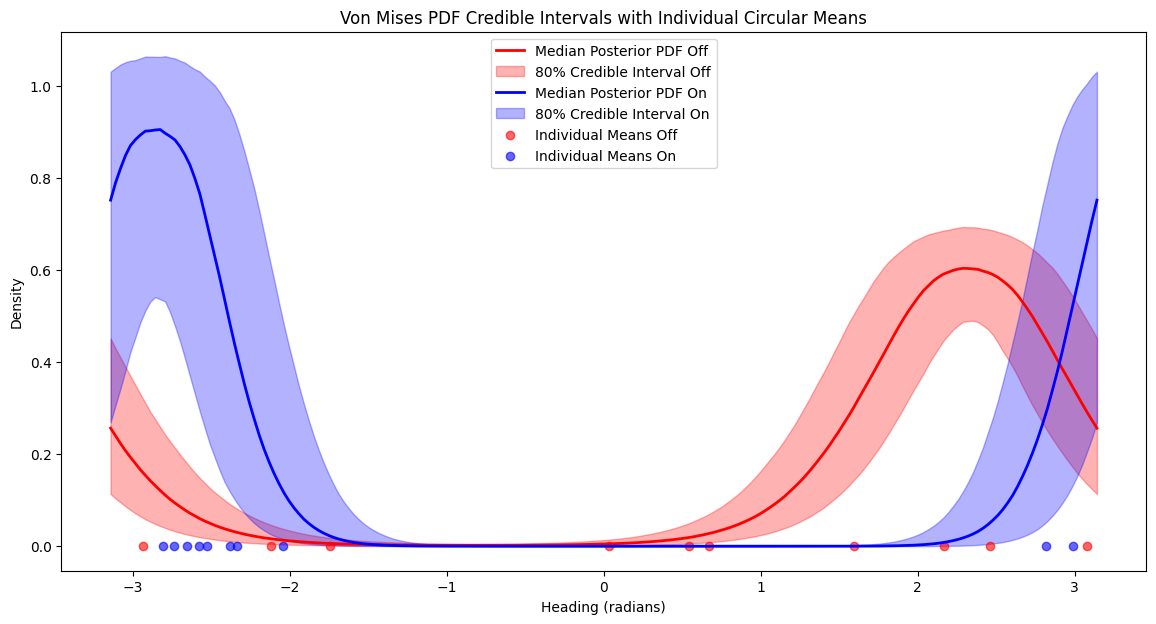

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import vonmises, circmean

# Import shifted_modulo and softplus from unwrap.link.numpy
from unwrap.link.numpy import shifted_modulo, softplus

# --------------------------------------------------
# Extract posterior samples for population-level parameters
# using the Bambi naming scheme with capitalized variable names.
# --------------------------------------------------
# For the μ-model (the main target):
mu_intercept = idata_tight.posterior['Intercept'].values          # fixed intercept for μ
mu_slope     = idata_tight.posterior['Light'].values               # fixed slope for μ

# For the κ-model:
kappa_intercept = idata_tight.posterior['kappa_Intercept'].values    # fixed intercept for κ (linear predictor)
kappa_slope     = idata_tight.posterior['kappa_Light'].values        # fixed slope for κ (linear predictor)

# --------------------------------------------------
# Prepare a grid for plotting the von Mises PDFs
# --------------------------------------------------
theta = np.linspace(-np.pi, np.pi, 200)

fig, ax = plt.subplots(figsize=(14, 7))

# Total number of posterior samples available.
num_samples = mu_intercept.flatten().shape[0]

# Compute population-level parameters for each condition.
mu_pop_off_samples_all = shifted_modulo(mu_intercept.flatten())
mu_pop_on_samples_all  = shifted_modulo((mu_intercept + mu_slope).flatten())
kappa_pop_off_samples_all = softplus(kappa_intercept.flatten())
kappa_pop_on_samples_all  = softplus((kappa_intercept + kappa_slope).flatten())

# --------------------------------------------------
# Compute the von Mises PDF for each posterior sample at each theta.
# The resulting arrays have shape (num_samples, len(theta)).
# --------------------------------------------------
pdf_off = vonmises.pdf(
    theta[None, :],
    kappa=kappa_pop_off_samples_all[:, None],
    loc=mu_pop_off_samples_all[:, None]
)
pdf_on = vonmises.pdf(
    theta[None, :],
    kappa=kappa_pop_on_samples_all[:, None],
    loc=mu_pop_on_samples_all[:, None]
)

# For each theta, compute the median and the 95% credible interval.
median_pdf_off = np.median(pdf_off, axis=0)
lower_pdf_off  = np.percentile(pdf_off, 10, axis=0)
upper_pdf_off  = np.percentile(pdf_off, 90, axis=0)

median_pdf_on = np.median(pdf_on, axis=0)
lower_pdf_on  = np.percentile(pdf_on, 10, axis=0)
upper_pdf_on  = np.percentile(pdf_on, 90, axis=0)

# --------------------------------------------------
# Plot the median PDFs and fill between the 95% credible intervals.
# --------------------------------------------------
ax.plot(theta, median_pdf_off, color='red', lw=2, label='Median Posterior PDF Off')
ax.fill_between(theta, lower_pdf_off, upper_pdf_off, color='red', alpha=0.3,
                label='80% Credible Interval Off')

ax.plot(theta, median_pdf_on, color='blue', lw=2, label='Median Posterior PDF On')
ax.fill_between(theta, lower_pdf_on, upper_pdf_on, color='blue', alpha=0.3,
                label='80% Credible Interval On')

# --------------------------------------------------
# Plot the circular means for each individual (individual-level summaries)
# --------------------------------------------------
for i, individual in enumerate(df['Individual'].unique()):
    individual_data = df[df['Individual'] == individual]
    
    # Get headings for Light Off (Light == 0) and Light On (Light == 1)
    headings_off = individual_data.loc[individual_data['Light'] == 0, 'HeadingRadians'].dropna()
    headings_on  = individual_data.loc[individual_data['Light'] == 1, 'HeadingRadians'].dropna()
    
    # Compute circular means for this individual and wrap into [-π, π] using shifted_modulo.
    individual_circmean_off = shifted_modulo(circmean(headings_off))
    individual_circmean_on  = shifted_modulo(circmean(headings_on))
    
    # Plot individual circular means.
    ax.scatter(individual_circmean_off, 0, color='red', alpha=0.6,
               label='Individual Means Off' if i == 0 else "")
    ax.scatter(individual_circmean_on, 0, color='blue', alpha=0.6,
               label='Individual Means On' if i == 0 else "")

ax.set_title('Von Mises PDF Credible Intervals with Individual Circular Means')
ax.set_xlabel('Heading (radians)')
ax.set_ylabel('Density')
ax.legend()
plt.show()


## Plot population-level predictions

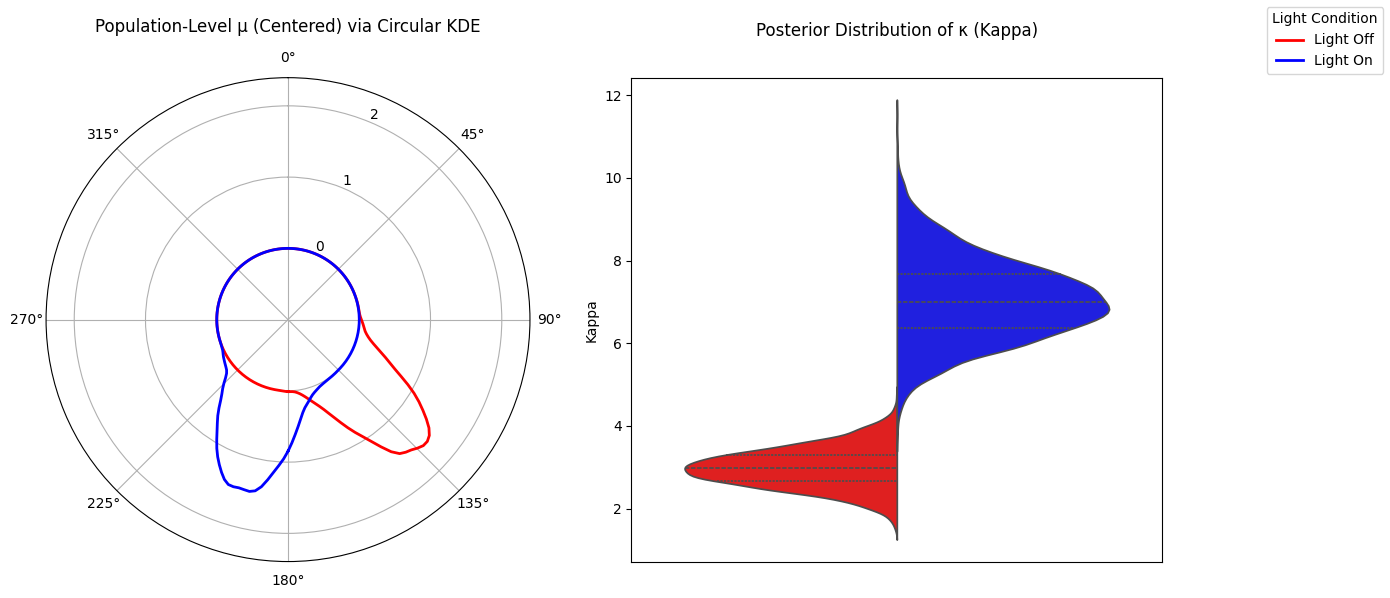

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import circmean, vonmises
from unwrap.link.numpy import shifted_modulo

# --------------------------------------------------
# Assume these arrays are computed from your posterior:
#   mu_pop_off_samples_all, mu_pop_on_samples_all,
#   kappa_pop_off_samples_all, kappa_pop_on_samples_all
# --------------------------------------------------

# ---------------------------
# Process μ (Mu) Samples
# ---------------------------
# Combine all μ samples to compute a common circular center.
mu_all = np.concatenate([mu_pop_off_samples_all, mu_pop_on_samples_all])
common_mu_center = circmean(mu_all, high=np.pi, low=-np.pi)

# Center the μ samples relative to the common center.
mu_off_centered = shifted_modulo(mu_pop_off_samples_all)
mu_on_centered  = shifted_modulo(mu_pop_on_samples_all)

# Set up an angular grid for the circular KDE.
theta = np.linspace(-np.pi, np.pi, 200)

# Choose a bandwidth (concentration) for the von Mises kernel.
kappa_bandwidth = 500  # Adjust as needed

# Compute the circular KDE for each condition.
# For each sample, evaluate the von Mises PDF at each theta, then average over samples.
kde_mu_off = np.mean(
    vonmises.pdf(theta[None, :],
                 kappa=kappa_bandwidth,
                 loc=mu_off_centered[:, None]),
    axis=0
)
kde_mu_on = np.mean(
    vonmises.pdf(theta[None, :],
                 kappa=kappa_bandwidth,
                 loc=mu_on_centered[:, None]),
    axis=0
)

# ---------------------------
# Process κ (Kappa) Samples
# ---------------------------
# For κ (a non-circular variable), no special centering is needed.
kappa_off = kappa_pop_off_samples_all
kappa_on  = kappa_pop_on_samples_all

# Create a DataFrame for the κ split violin plot.
df_kappa = pd.DataFrame({
    "Parameter": ["Kappa"] * (len(kappa_off) + len(kappa_on)),
    "Light": ["Light Off"] * len(kappa_off) + ["Light On"] * len(kappa_on),
    "Value": np.concatenate([kappa_off, kappa_on])
})

# --------------------------------------------------
# Create Subplots: a Polar Plot for μ and a Violin Plot for κ
# --------------------------------------------------
fig = plt.figure(figsize=(14, 6))

# (A) Polar subplot for μ.
ax1 = fig.add_subplot(1, 2, 1, projection='polar')
# Set axes to geographic format (clockwise, 0° at the top)
ax1.set_theta_zero_location('N')#place 0° at the top
ax1.set_theta_direction(-1)#reverse to clockwise
# Add an offset of 1 unit to the density so there's white space in the center.
ax1.plot(theta, kde_mu_off + 1, color='red', lw=2, label='Light Off')
ax1.plot(theta, kde_mu_on + 1, color='blue', lw=2, label='Light On')
ax1.set_title("Population-Level μ (Centered) via Circular KDE", va='bottom', pad=30)
# Adjust radial limits: add 1 (the offset) to the maximum density and a little extra space.
max_density = max(np.max(kde_mu_off), np.max(kde_mu_on))
ax1.set_rlim(0, 1 + max_density * 1.5)
ax1.set_rticks([1, 2, 3], [0, 1, 2])
# (B) Cartesian subplot for κ.
ax2 = fig.add_subplot(1, 2, 2)
sns.violinplot(x="Parameter", y="Value", hue="Light",
               data=df_kappa, split=True, inner="quartile",
               palette={"Light Off": "red", "Light On": "blue"},
               ax=ax2)
ax2.set_title("Posterior Distribution of κ (Kappa)", pad=30)
ax2.set_xlabel("")
ax2.set_ylabel("Kappa")
ax2.set_xticks([])
# --------------------------------------------------
# Create a Common Legend for Both Subplots
# --------------------------------------------------
# Remove individual legends from each subplot.
if ax1.get_legend() is not None:
    ax1.get_legend().remove()
if ax2.get_legend() is not None:
    ax2.get_legend().remove()

# Extract legend handles and labels from one of the subplots.
handles, labels = ax1.get_legend_handles_labels()

# Place a common legend for the entire figure.
fig.legend(handles, labels, title="Light Condition", loc="upper right")

plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust layout to leave space for the legend.
plt.show()


# Model with larger treatment effect on hyperparameters
Here we wider the priors on hyperparameters, putting a strong positive bias on the $\kappa_\mu$ hyperparameters since by default we expect strong agreement (partial pooling) for estimates across individuals.

In [28]:
# from fastprogress import fastprogress
# fastprogress.printing = lambda: True

import numpy as np
import pandas as pd
import bambi as bmb
import arviz as az
import matplotlib.pyplot as plt

from unwrap.link.bambi import LINKS
from unwrap.link.numpy import inverse_softplus
from unwrap.prior import CircularUniformPrior

# Define the model formula with updated, capitalized variable names.
formula_wide = bmb.Formula(
    "HeadingRadians ~ Light + (1 + Light|Individual)",
    "kappa ~ Light + (1 + Light|Individual)",
)

# Specify priors for the model with capitalized keys and updated variable names.
priors_wide= {
    # Fixed effects for μ:
    "Intercept": CircularUniformPrior(),
    # "Light": bmb.Prior("Normal", mu=0, sigma= 0.75 * np.pi),#wider
    "Light": bmb.Prior("VonMises", mu=0, kappa= 1.0),#von Mises
    # Individual-level effects for μ:
    "1|Individual": bmb.Prior(
        # "VonMises", mu=0, kappa=bmb.Prior("LogNormal", mu=np.log(5), sigma=0.1)
        "VonMises", mu=0, kappa=bmb.Prior("LogNormal", mu=np.log(30), sigma=0.6) # 20251021 proposed shrinkage prior
        # "VonMises", mu=0, kappa=bmb.Prior("LogNormal", mu=np.log(5), sigma=0.6) # 20251023 still divergences, try even lower value?
    ),
    "Light|Individual": bmb.Prior(
        # "Normal", mu=0, sigma=bmb.Prior("LogNormal", mu=np.log(0.25), sigma=0.1)
        "VonMises", mu=0, kappa=bmb.Prior("LogNormal", mu=np.log(30), sigma=0.6) # my assumed potential for large changes 
    ),
    # Priors for the κ-model (inside the "kappa" dictionary):
    "kappa": {
        # Fixed effects for κ:
        # "Intercept": bmb.Prior("Normal", mu=inverse_softplus(2), sigma=1),
        "Intercept": bmb.Prior("Normal", mu=inverse_softplus(3), sigma=1.5),#wider possible range
        # "Light": bmb.Prior("Normal", mu=0, sigma=2.5),
        "Light": bmb.Prior("Normal", mu=0, sigma=3.0),#slightly wider
        # Individual-level effects for κ:
        "1|Individual": bmb.Prior(
            # "Normal", mu=0, sigma=bmb.Prior("LogNormal", mu=np.log(0.5), sigma=0.1)
            "Normal", mu=0, sigma=bmb.Prior("HalfStudentT", nu = 3, sigma=1.5)#much wider
        ),
        "Light|Individual": bmb.Prior(
            # "Normal", mu=0, sigma=bmb.Prior("LogNormal", mu=np.log(0.5), sigma=0.1)
            "Normal", mu=0, sigma=bmb.Prior("HalfStudentT", nu = 3, sigma=1.0)#much wider
        ),
    },
}

# Build the model using the updated formula and priors.
model_wide = bmb.Model(
    formula_wide,
    df,
    family="vonmises",
    priors=priors_wide,
    link={"mu": LINKS["shifted_modulo"], "kappa": LINKS["softplus"]},
    center_predictors=False,
    dropna=True,
)

print(model_wide)

# Fit the model.
idata_wide = model_wide.fit(draws=1000,
                            # inference_method="nutpie",#faster
                            idata_kwargs={"log_likelihood": True},
                            sample_kwargs={
        "tune_kwargs": {
            "target_accept": 0.95  # Needs sampling with small steps
        }
    })


       Formula: HeadingRadians ~ Light + (1 + Light|Individual)
                kappa ~ Light + (1 + Light|Individual)
        Family: vonmises
          Link: mu = shifted_modulo
                kappa = softplus
  Observations: 196
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ CircularUniform()
            Light ~ VonMises(mu: 0.0, kappa: 1.0)
        
        Group-level effects
            1|Individual ~ VonMises(mu: 0.0, kappa: LogNormal(mu: 3.4012, sigma: 0.6))
            Light|Individual ~ VonMises(mu: 0.0, kappa: LogNormal(mu: 3.4012, sigma: 0.6))
    target = kappa
        Common-level effects
            kappa_Intercept ~ Normal(mu: 2.9489, sigma: 1.5)
            kappa_Light ~ Normal(mu: 0.0, sigma: 3.0)
        
        Group-level effects
            kappa_1|Individual ~ Normal(mu: 0.0, sigma: HalfStudentT(nu: 3.0, sigma: 1.5))
            kappa_Light|Individual ~ Normal(mu: 0.0, sigma: HalfStudentT(nu: 3.0, sigma: 1.0))


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, Light, 1|Individual_kappa, 1|Individual, Light|Individual_kappa, Light|Individual, kappa_Intercept, kappa_Light, kappa_1|Individual_sigma, kappa_1|Individual_offset, kappa_Light|Individual_sigma, kappa_Light|Individual_offset]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 155 seconds.


## Inspect summary


In [29]:
az.summary(
    idata_wide, 
    var_names=["Intercept", "Light", "kappa_Intercept", "kappa_Light", "1|Individual_kappa", "Light|Individual_kappa",
                "kappa_1|Individual_sigma", "kappa_Light|Individual_sigma"],
    circ_var_names=["Intercept", "Light"]
)

mean     sd  hdi_3%  hdi_97%  mcse_mean  \
Intercept                     2.248  0.520   1.312   -3.055      0.011   
Light                         1.295  0.296   0.755    1.843      0.009   
kappa_Intercept               4.285  0.720   3.004    5.668      0.015   
kappa_Light                   4.505  2.143   0.295    8.437      0.045   
1|Individual_kappa            1.845  0.477   1.005    2.749      0.007   
Light|Individual_kappa        2.771  0.761   1.379    4.161      0.012   
kappa_1|Individual_sigma      1.669  0.937   0.024    3.233      0.027   
kappa_Light|Individual_sigma  7.407  4.335   1.037   15.512      0.133   

                              mcse_sd  ess_bulk  ess_tail  r_hat  
Intercept                       0.035     888.0    1036.0    1.0  
Light                           0.007     828.0    1364.0    1.0  
kappa_Intercept                 0.010    2368.0    2765.0    1.0  
kappa_Light                     0.032    2356.0    2058.0    1.0  
1|Individual_kappa              0.005    4946.0    3161.0    1.0  
Light|Individual_kappa          0.009    4256.0    3029.0    1.0  
kappa_1|Individual_sigma        0.019    1090.0     973.0    1.0  
kappa_Light|Individual_sigma    0.094     975.0    1304.0    1.0

In [30]:
az.summary(
    idata_wide, 
    var_names=["1|Individual", "Light|Individual",
                "kappa_1|Individual", "kappa_Light|Individual"],
    circ_var_names=["1|Individual", "Light|Individual"]
)

mean     sd  hdi_3%  hdi_97%  mcse_mean  \
1|Individual[1]             -1.391  0.562  -2.514   -0.392      0.011   
1|Individual[2]              0.200  0.530  -0.760    1.247      0.009   
1|Individual[3]             -2.112  0.555   3.066   -1.111      0.009   
1|Individual[4]              1.808  0.549   0.750    2.807      0.009   
1|Individual[5]             -0.601  0.526  -1.599    0.372      0.009   
1|Individual[6]              2.214  0.550   1.174   -3.045      0.012   
1|Individual[7]              0.743  0.536  -0.310    1.731      0.010   
1|Individual[8]              1.034  0.533   0.025    2.025      0.012   
1|Individual[9]             -1.642  0.535  -2.640   -0.637      0.011   
1|Individual[10]            -0.068  0.529  -1.057    0.936      0.011   
Light|Individual[1]          1.300  0.379   0.567    1.985      0.009   
Light|Individual[2]         -0.042  0.333  -0.646    0.595      0.008   
Light|Individual[3]          1.350  0.357   0.678    2.029      0.011   
Light|Individual[4]         -1.581  0.349  -2.214   -0.939      0.009   
Light|Individual[5]          0.680  0.324   0.067    1.282      0.009   
Light|Individual[6]         -1.491  0.343  -2.191   -0.893      0.007   
Light|Individual[7]         -0.310  0.360  -1.044    0.317      0.009   
Light|Individual[8]         -0.666  0.325  -1.265   -0.044      0.007   
Light|Individual[9]          0.791  0.521  -0.218    1.795      0.013   
Light|Individual[10]         0.067  0.343  -0.552    0.748      0.008   
kappa_1|Individual[1]       -1.015  1.230  -3.484    1.046      0.025   
kappa_1|Individual[2]       -0.535  1.162  -2.820    1.580      0.020   
kappa_1|Individual[3]        0.451  1.321  -2.072    2.930      0.022   
kappa_1|Individual[4]        0.590  1.408  -1.896    3.570      0.023   
kappa_1|Individual[5]        1.258  1.625  -1.562    4.270      0.030   
kappa_1|Individual[6]        1.501  1.777  -1.373    4.849      0.035   
kappa_1|Individual[7]       -1.214  1.167  -3.553    0.631      0.026   
kappa_1|Individual[8]        1.278  1.678  -1.598    4.423      0.032   
kappa_1|Individual[9]        1.305  1.782  -1.654    4.855      0.036   
kappa_1|Individual[10]      -1.132  1.162  -3.271    0.945      0.025   
kappa_Light|Individual[1]    2.563  4.322  -5.233   10.532      0.083   
kappa_Light|Individual[2]    3.807  4.690  -4.089   12.928      0.083   
kappa_Light|Individual[3]   -0.691  3.592  -7.865    5.806      0.062   
kappa_Light|Individual[4]    7.554  7.025  -3.235   20.655      0.160   
kappa_Light|Individual[5]    9.668  8.767  -3.174   25.910      0.218   
kappa_Light|Individual[6]    1.837  4.464  -5.862   10.984      0.079   
kappa_Light|Individual[7]   -3.970  2.674  -8.856    1.160      0.055   
kappa_Light|Individual[8]    6.237  6.421  -3.751   18.945      0.135   
kappa_Light|Individual[9]   -8.305  4.819 -15.859   -0.227      0.127   
kappa_Light|Individual[10]  11.301  9.259  -1.017   29.326      0.242   

                            mcse_sd  ess_bulk  ess_tail  r_hat  
1|Individual[1]               0.019     602.0    1248.0    1.0  
1|Individual[2]               0.017     488.0    1065.0    1.0  
1|Individual[3]               0.032     934.0    1088.0    1.0  
1|Individual[4]               0.021     631.0    1163.0    1.0  
1|Individual[5]               0.017     488.0     905.0    1.0  
1|Individual[6]               0.037    1083.0    1067.0    1.0  
1|Individual[7]               0.016     569.0     993.0    1.0  
1|Individual[8]               0.017     519.0     991.0    1.0  
1|Individual[9]               0.020     597.0    1027.0    1.0  
1|Individual[10]              0.016     524.0    1077.0    1.0  
Light|Individual[1]           0.008    1174.0    1643.0    1.0  
Light|Individual[2]           0.007    1153.0    1808.0    1.0  
Light|Individual[3]           0.008    1109.0    1725.0    1.0  
Light|Individual[4]           0.008    1040.0    1644.0    1.0  
Light|Individual[5]           0.007     992.0    1823.0    1.

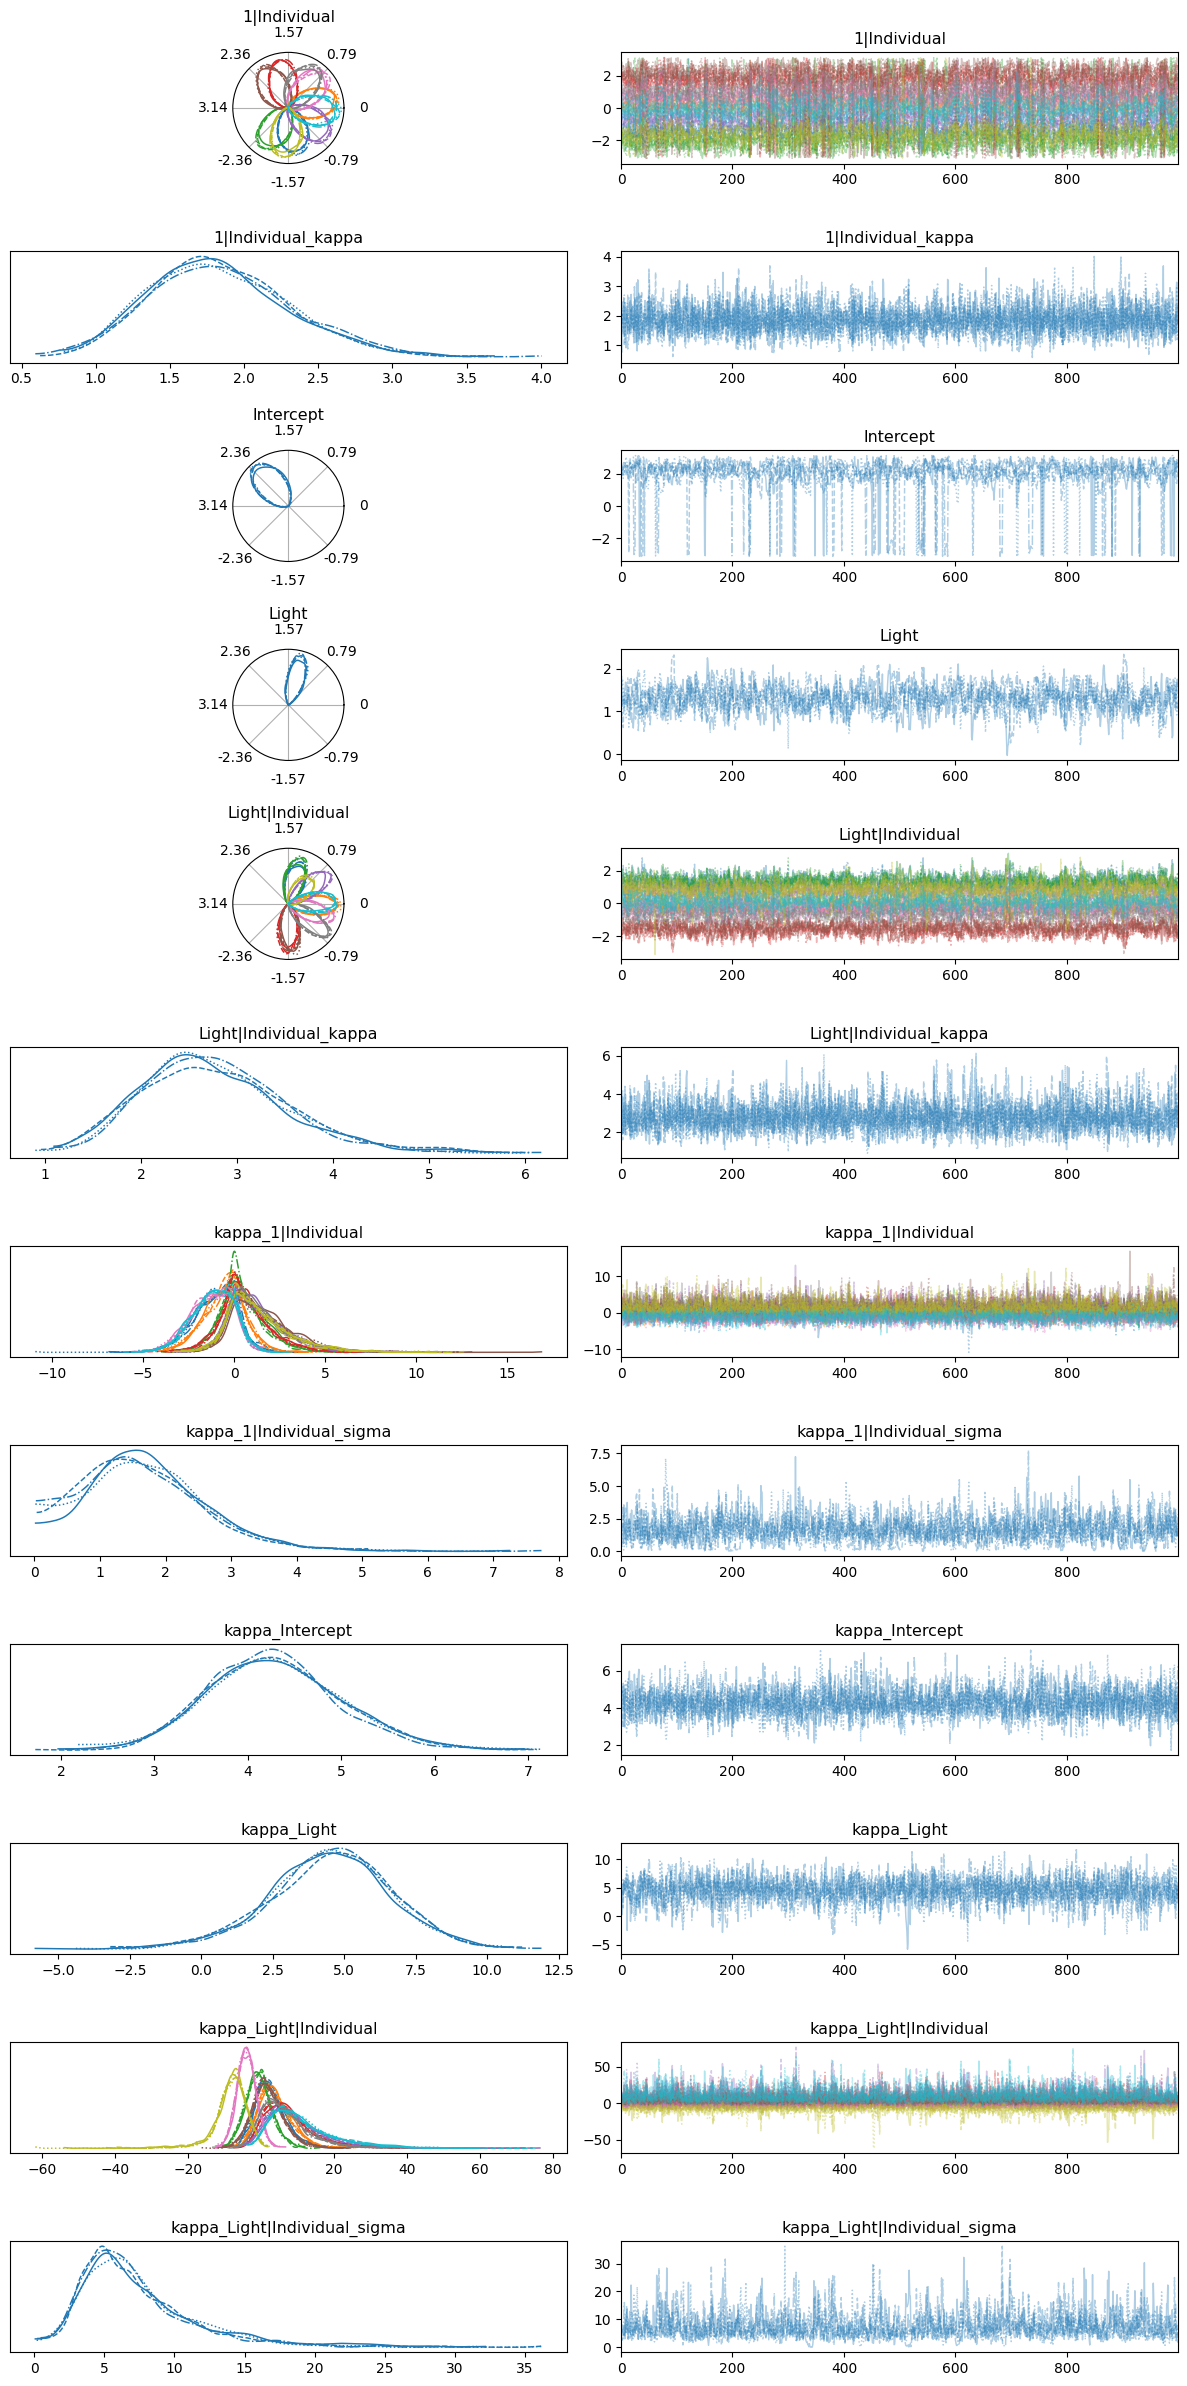

In [31]:
# varnms = ["Intercept", "Light", "kappa_Intercept", "kappa_Light"],
#Specify which parameters are circular
cvars = ["Intercept", "Light", "1|Individual", "Light|Individual"]
#transform the circular data for interpretability
idata_wide_trans = idata_wide.copy() # set up a variable for transformed data
# for cvar in cvars:
#     idata_wide_trans.posterior[cvar] = -180*idata_wide_trans.posterior[cvar]/np.pi # convert each to degrees that will plot clockwise

az.plot_trace(idata_wide,
            #   var_names=varnms,
              circ_var_names=cvars,
              #circ_var_units='degrees'
              ) #now in degrees and going clockwise, but axis labels are anticlock and start at right
plt.tight_layout()
plt.show()

# Model no change in $\kappa_\mu$
Our hypothesis is that turning on the light increased the correlation across individual headings. We could test this by excluding the effect of light on the population of individual headings.

In [41]:
# from fastprogress import fastprogress
# fastprogress.printing = lambda: True

import numpy as np
import pandas as pd
import bambi as bmb
import arviz as az
import matplotlib.pyplot as plt

from unwrap.link.bambi import LINKS
from unwrap.link.numpy import inverse_softplus
from unwrap.prior import CircularUniformPrior

# Define the model formula with updated, capitalized variable names.
formula_nolightkm = bmb.Formula(
    "HeadingRadians ~ Light + (1|Individual)",
    "kappa ~ Light + (1 + Light|Individual)",
)

# Specify priors for the model with capitalized keys and updated variable names.
priors_nolightkm= {
    # Fixed effects for μ:
    "Intercept": CircularUniformPrior(),
    "Light": bmb.Prior("VonMises", mu=0, kappa= 1.0),#For this model this parameter is now difficult to estimate (as we would expect), loosening helps?
    # Individual-level effects for μ:
    "1|Individual": bmb.Prior(
        # "VonMises", mu=0, kappa=bmb.Prior("LogNormal", mu=np.log(5), sigma=0.1)
        "VonMises", mu=0, kappa=bmb.Prior("LogNormal", mu=np.log(30), sigma=0.6) # 20251022 needs to be low to converge?
    ),
    # "Light|Individual": bmb.Prior(
    #     # "Normal", mu=0, sigma=bmb.Prior("LogNormal", mu=np.log(0.25), sigma=0.1)
    #     "VonMises", mu=0, kappa=100 # the light has almost no effect on individual headings (Mardia SD≈6°)
    # ),
    # Priors for the κ-model (inside the "kappa" dictionary):
    "kappa": {
        # Fixed effects for κ:
        # "Intercept": bmb.Prior("Normal", mu=inverse_softplus(2), sigma=1),
        "Intercept": bmb.Prior("Normal", mu=inverse_softplus(1.0), sigma=3.0),#combined expected to be lower
        # "Light": bmb.Prior("Normal", mu=0, sigma=2.5),
        "Light": bmb.Prior("Normal", mu=0, sigma=1.0),#narrower
        # Individual-level effects for κ:
        "1|Individual": bmb.Prior(
            # "Normal", mu=0, sigma=bmb.Prior("LogNormal", mu=np.log(0.5), sigma=0.1)
            "Normal", mu=0, sigma=bmb.Prior("HalfStudentT", nu = 3, sigma=0.5)#narrower for stability
        ),
        "Light|Individual": bmb.Prior(
            # "Normal", mu=0, sigma=bmb.Prior("LogNormal", mu=np.log(0.5), sigma=0.1)
            "Normal", mu=0, sigma=bmb.Prior("HalfStudentT", nu = 3, sigma=0.5)#narrower for stability
        ),
    },
}

# Build the model using the updated formula and priors.
model_nolightkm = bmb.Model(
    formula_nolightkm,
    df,
    family="vonmises",
    priors=priors_nolightkm,
    link={"mu": LINKS["shifted_modulo"], "kappa": LINKS["softplus"]},
    center_predictors=False,
    dropna=True,
)

print(model_nolightkm)

# Fit the model.
idata_nolightkm = model_nolightkm.fit(draws=1000,
                            idata_kwargs={"log_likelihood": True},
                            sample_kwargs={
        "tune_kwargs": {
            "target_accept": 0.97  # Set your desired value (e.g., 0.95)
        }
    })


       Formula: HeadingRadians ~ Light + (1|Individual)
                kappa ~ Light + (1 + Light|Individual)
        Family: vonmises
          Link: mu = shifted_modulo
                kappa = softplus
  Observations: 196
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ CircularUniform()
            Light ~ VonMises(mu: 0.0, kappa: 1.0)
        
        Group-level effects
            1|Individual ~ VonMises(mu: 0.0, kappa: LogNormal(mu: 3.4012, sigma: 0.6))
    target = kappa
        Common-level effects
            kappa_Intercept ~ Normal(mu: 0.5413, sigma: 3.0)
            kappa_Light ~ Normal(mu: 0.0, sigma: 1.0)
        
        Group-level effects
            kappa_1|Individual ~ Normal(mu: 0.0, sigma: HalfStudentT(nu: 3.0, sigma: 0.5))
            kappa_Light|Individual ~ Normal(mu: 0.0, sigma: HalfStudentT(nu: 3.0, sigma: 0.5))


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, Light, 1|Individual_kappa, 1|Individual, kappa_Intercept, kappa_Light, kappa_1|Individual_sigma, kappa_1|Individual_offset, kappa_Light|Individual_sigma, kappa_Light|Individual_offset]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 87 seconds.
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [42]:
az.summary(
    idata_nolightkm, 
    var_names=["Intercept", "Light", "kappa_Intercept", "kappa_Light", "1|Individual_kappa",
                "kappa_1|Individual_sigma"],
    circ_var_names=["Intercept", "Light"]
)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Intercept                 1.412  0.414   0.764    2.214      0.013    0.028   
Light                     2.181  0.409   1.325    2.783      0.012    0.020   
kappa_Intercept           0.412  1.494  -2.447    3.190      0.042    0.030   
kappa_Light               0.511  1.007  -1.384    2.364      0.016    0.014   
1|Individual_kappa        8.712  3.382   3.170   14.928      0.102    0.072   
kappa_1|Individual_sigma  4.370  1.885   1.435    7.988      0.054    0.038   

                          ess_bulk  ess_tail  r_hat  
Intercept                    649.0     485.0   1.00  
Light                        398.0     253.0   1.01  
kappa_Intercept             1259.0    1966.0   1.00  
kappa_Light                 4037.0    3096.0   1.00  
1|Individual_kappa           819.0    1002.0   1.00  
kappa_1|Individual_sigma    1110.0    1813.0   1.00

In [43]:
az.summary(
    idata_wide, 
    var_names=["1|Individual", "Light|Individual",
                "kappa_1|Individual"],
    circ_var_names=["1|Individual", "Light|Individual"]
)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
1|Individual[1]        -1.391  0.562  -2.514   -0.392      0.011    0.019   
1|Individual[2]         0.200  0.530  -0.760    1.247      0.009    0.017   
1|Individual[3]        -2.112  0.555   3.066   -1.111      0.009    0.032   
1|Individual[4]         1.808  0.549   0.750    2.807      0.009    0.021   
1|Individual[5]        -0.601  0.526  -1.599    0.372      0.009    0.017   
1|Individual[6]         2.214  0.550   1.174   -3.045      0.012    0.037   
1|Individual[7]         0.743  0.536  -0.310    1.731      0.010    0.016   
1|Individual[8]         1.034  0.533   0.025    2.025      0.012    0.017   
1|Individual[9]        -1.642  0.535  -2.640   -0.637      0.011    0.020   
1|Individual[10]       -0.068  0.529  -1.057    0.936      0.011    0.016   
Light|Individual[1]     1.300  0.379   0.567    1.985      0.009    0.008   
Light|Individual[2]    -0.042  0.333  -0.646    0.595      0.008    0.007   
Light|Individual[3]     1.350  0.357   0.678    2.029      0.011    0.008   
Light|Individual[4]    -1.581  0.349  -2.214   -0.939      0.009    0.008   
Light|Individual[5]     0.680  0.324   0.067    1.282      0.009    0.007   
Light|Individual[6]    -1.491  0.343  -2.191   -0.893      0.007    0.008   
Light|Individual[7]    -0.310  0.360  -1.044    0.317      0.009    0.007   
Light|Individual[8]    -0.666  0.325  -1.265   -0.044      0.007    0.007   
Light|Individual[9]     0.791  0.521  -0.218    1.795      0.013    0.010   
Light|Individual[10]    0.067  0.343  -0.552    0.748      0.008    0.007   
kappa_1|Individual[1]  -1.015  1.230  -3.484    1.046      0.025    0.018   
kappa_1|Individual[2]  -0.535  1.162  -2.820    1.580      0.020    0.016   
kappa_1|Individual[3]   0.451  1.321  -2.072    2.930      0.022    0.018   
kappa_1|Individual[4]   0.590  1.408  -1.896    3.570      0.023    0.020   
kappa_1|Individual[5]   1.258  1.625  -1.562    4.270      0.030    0.021   
kappa_1|Individual[6]   1.501  1.777  -1.373    4.849      0.035    0.025   
kappa_1|Individual[7]  -1.214  1.167  -3.553    0.631      0.026    0.019   
kappa_1|Individual[8]   1.278  1.678  -1.598    4.423      0.032    0.023   
kappa_1|Individual[9]   1.305  1.782  -1.654    4.855      0.036    0.025   
kappa_1|Individual[10] -1.132  1.162  -3.271    0.945      0.025    0.018   

                        ess_bulk  ess_tail  r_hat  
1|Individual[1]            602.0    1248.0    1.0  
1|Individual[2]            488.0    1065.0    1.0  
1|Individual[3]            934.0    1088.0    1.0  
1|Individual[4]            631.0    1163.0    1.0  
1|Individual[5]            488.0     905.0    1.0  
1|Individual[6]           1083.0    1067.0    1.0  
1|Individual[7]            569.0     993.0    1.0  
1|Individual[8]            519.0     991.0    1.0  
1|Individual[9]            597.0    1027.0    1.0  
1|Individual[10]           524.0    1077.0    1.0  
Light|Individual[1]       1174.0    1643.0    1.0  
Light|Individual[2]       1153.0    1808.0    1.0  
Light|Individual[3]       1109.0    1725.0    1.0  
Light|Individual[4]       1040.0    1644.0    1.0  
Light|Individual[5]        992.0    1823.0    1.0  
Light|Individual[6]       1019.0    1834.0    1.0  
Light|Individual[7]       1376.0    2081.0    1.0  
Light|Individual[8]        971.0    1527.0    1.0  
Light|Individual[9]       1658.0    1426.0    1.0  
Light|Individual[10]      1130.0    1473.0    1.0  
kappa_1|Individual[1]     2336.0    3014.0    1.0  
kappa_1|Individual[2]     3359.0    3160.0    1.0  
kappa_1|Individual[3]     3558.0    3260.0    1.0  
kappa_1|Individual[4]     3973.0    2977.0    1.0  
kappa_1|Individual[5]     2866.0    3425.0    1.0  
kappa_1|Individual[6]     2434.0    3086.0    1.0  
kappa_1|Individual[7]     1912.0    2728.0    1.0  
kappa_1|Individual[8]     2816.0    3161.0    1.0  
kappa_1|Individual[9]     2469.0    3044.0    1.0  
kappa_1|Individual[10]    2191.0    3277.0    1.0

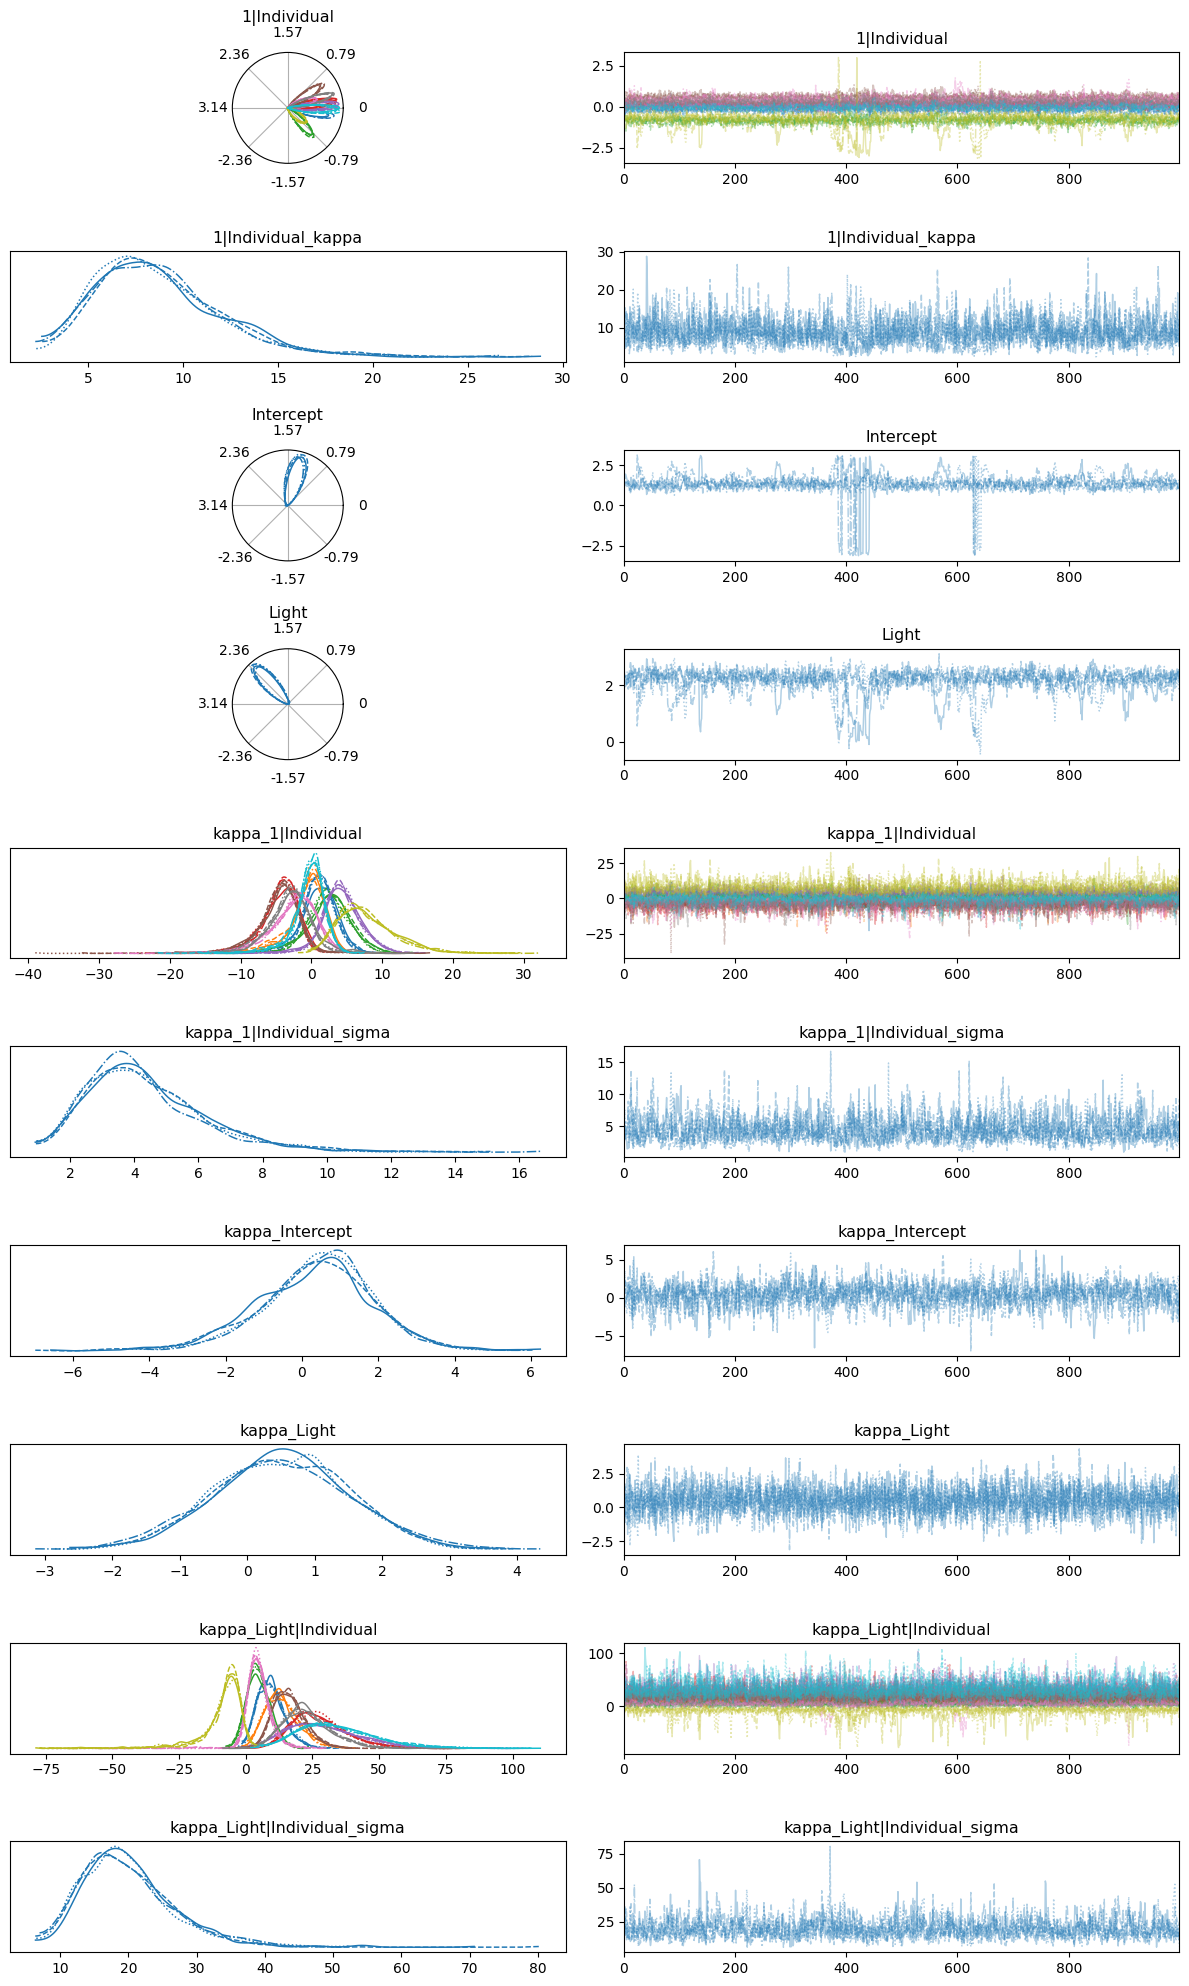

In [44]:
# varnms = ["Intercept", "Light", "kappa_Intercept", "kappa_Light"],
#Specify which parameters are circular
cvars = ["Intercept", "Light", "1|Individual", "Light|Individual"]
#transform the circular data for interpretability
# for cvar in cvars:
#     idata_wide_trans.posterior[cvar] = -180*idata_wide_trans.posterior[cvar]/np.pi # convert each to degrees that will plot clockwise

az.plot_trace(idata_nolightkm,
            #   var_names=varnms,
              circ_var_names=cvars,
              #circ_var_units='degrees'
              ) #now in degrees and going clockwise, but axis labels are anticlock and start at right
plt.tight_layout()
plt.show()

# Model comparison for hypothesis testing
Initially, just compare the restrictive and loosened prior models


In [36]:
#First the log likelihood function needs to be computed for each model and dataset

# model_tight.compute_log_likelihood(idata_wide)
# # model_wide.compute_log_likelihood(idata_wide)
# import pymc as pm
# pm.compute_log_likelihood(idata_wide, model = model_tight)
# pm.compute_log_likelihood(idata_wide, model = model_wide)



In [45]:
#Calculate predictive power using LOO cross-validation
import pymc as pm
loo_tight = az.loo(idata_wide)
loo_wide = az.loo(idata_wide)
loo_nolightkm = az.loo(idata_nolightkm)
# loo_wide = az.reloo(loo_orig=loo_wide,
#                     wrapper=az.SamplingWrapper(model_wide),
#                     k_thresh = 0.7)

C:\Users\James Foster\AppData\Roaming\Python\Python312\site-packages\arviz\stats\stats.py:792: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
C:\Users\James Foster\AppData\Roaming\Python\Python312\site-packages\arviz\stats\stats.py:792: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
C:\Users\James Foster\AppDat

In [46]:
#print the results
print('\n----- Tight -----\n')
print(loo_tight)
print('\n----- Wide -----\n')
print(loo_wide)
print('\n----- No light kappa_mu -----\n')
print(loo_nolightkm)
#some warnings in a small proportion of cases, but predictions are generally accurate

#compare, ranking models from best to worst
az.compare({'Tight':loo_tight,
            'Wide':loo_wide,
            'No light': loo_nolightkm
            }, 
            ic="loo")


----- Tight -----

Computed from 4000 posterior samples and 196 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -122.02    15.96
p_loo       34.74        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)      189   96.4%
   (0.70, 1]   (bad)         5    2.6%
   (1, Inf)   (very bad)    2    1.0%


----- Wide -----

Computed from 4000 posterior samples and 196 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -122.02    15.96
p_loo       34.74        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)      189   96.4%
   (0.70, 1]   (bad)         5    2.6%
   (1, Inf)   (very bad)    2    1.0%


----- No light kappa_mu -----

Computed from 4000 posterior samples and 196 observations log-likelih

rank    elpd_loo      p_loo  elpd_diff    weight         se  \
Tight        0 -122.018574  34.736889   0.000000  0.481454  15.955995   
Wide         1 -122.018574  34.736889   0.000000  0.481454  15.955995   
No light     2 -180.006922  37.933858  57.988348  0.037093  15.736285   

                dse  warning scale  
Tight      0.000000     True   log  
Wide       0.000000     True   log  
No light  10.392272     True   log

# Inspect the change in $\kappa_\mu$

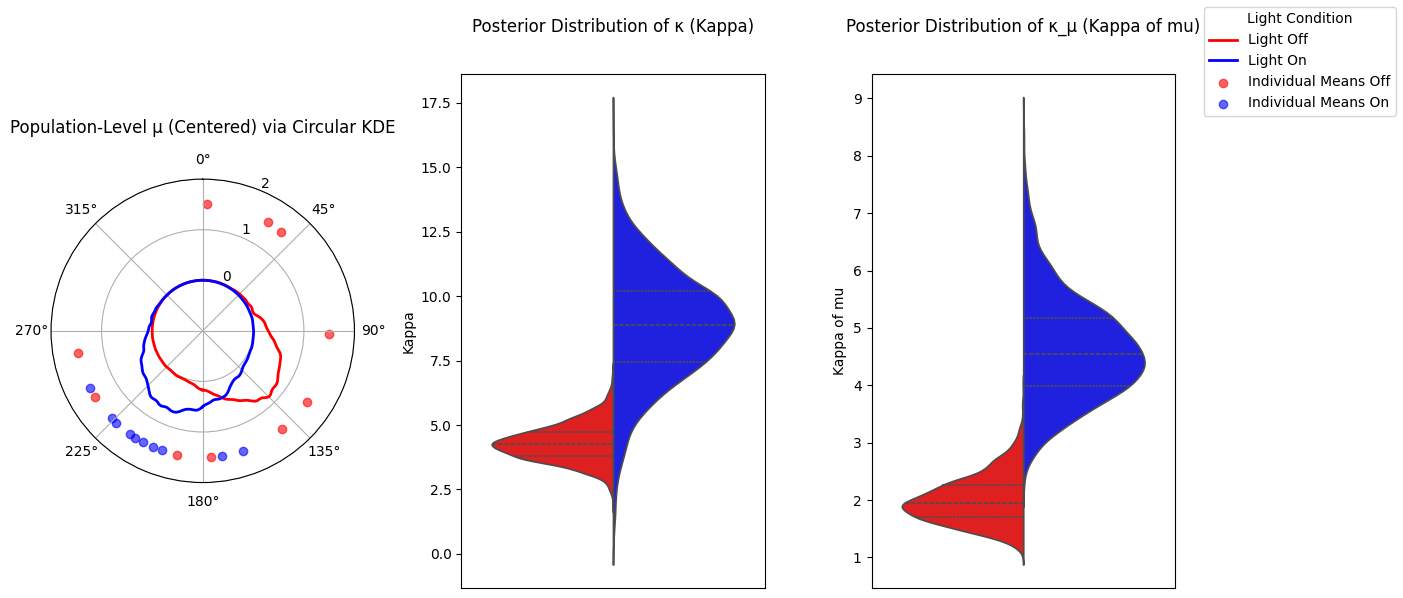

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import circmean, vonmises
from unwrap.link.numpy import shifted_modulo

# --------------------------------------------------
# Extract posterior samples for population-level parameters
# using the Bambi naming scheme with capitalized variable names.
# --------------------------------------------------
# For the μ-model (the main target):
mu_intercept = idata_wide.posterior['Intercept'].values          # fixed intercept for μ
mu_slope     = idata_wide.posterior['Light'].values               # fixed slope for μ

# For the κ-model:
kappa_intercept = idata_wide.posterior['kappa_Intercept'].values    # fixed intercept for κ (linear predictor)
kappa_slope     = idata_wide.posterior['kappa_Light'].values        # fixed slope for κ (linear predictor)

# For the κ_μ-model:
kappamu_intercept = idata_wide.posterior["1|Individual_kappa"].values    # fixed intercept for κ_μ (linear predictor)
kappamu_slope     = idata_wide.posterior["Light|Individual_kappa"].values        # fixed slope for κ_μ (linear predictor)

# --------------------------------------------------
# Prepare a grid for plotting the von Mises PDFs
# --------------------------------------------------
theta = np.linspace(-np.pi, np.pi, 200)

# fig, ax = plt.subplots(figsize=(14, 7))

# Total number of posterior samples available.
num_samples = mu_intercept.flatten().shape[0]

# Compute population-level parameters for each condition.
mu_pop_off_samples_all = shifted_modulo(mu_intercept.flatten())
mu_pop_on_samples_all  = shifted_modulo((mu_intercept + mu_slope).flatten())
kappa_pop_off_samples_all = softplus(kappa_intercept.flatten())
kappa_pop_on_samples_all  = softplus((kappa_intercept + kappa_slope).flatten())
kappamu_pop_off_samples_all = softplus(kappamu_intercept.flatten())
kappamu_pop_on_samples_all  = softplus((kappamu_intercept + kappamu_slope).flatten())

# --------------------------------------------------
# Assume these arrays are computed from your posterior:
#   mu_pop_off_samples_all, mu_pop_on_samples_all,
#   kappa_pop_off_samples_all, kappa_pop_on_samples_all
# --------------------------------------------------

# ---------------------------
# Process μ (Mu) Samples
# ---------------------------
# Combine all μ samples to compute a common circular center.
mu_all = np.concatenate([mu_pop_off_samples_all, mu_pop_on_samples_all])
common_mu_center = circmean(mu_all, high=np.pi, low=-np.pi)

# Center the μ samples relative to the common center.
mu_off_centered = shifted_modulo(mu_pop_off_samples_all)
mu_on_centered  = shifted_modulo(mu_pop_on_samples_all)

# Set up an angular grid for the circular KDE.
theta = np.linspace(-np.pi, np.pi, 200)

# Choose a bandwidth (concentration) for the von Mises kernel.
kappa_bandwidth = 500  # Adjust as needed

# Compute the circular KDE for each condition.
# For each sample, evaluate the von Mises PDF at each theta, then average over samples.
kde_mu_off = np.mean(
    vonmises.pdf(theta[None, :],
                 kappa=kappa_bandwidth,
                 loc=mu_off_centered[:, None]),
    axis=0
)
kde_mu_on = np.mean(
    vonmises.pdf(theta[None, :],
                 kappa=kappa_bandwidth,
                 loc=mu_on_centered[:, None]),
    axis=0
)


# ---------------------------
# Process κ (Kappa) Samples
# ---------------------------
# For κ (a non-circular variable), no special centering is needed.
kappa_off = kappa_pop_off_samples_all
kappa_on  = kappa_pop_on_samples_all

# Create a DataFrame for the κ split violin plot.
df_kappa = pd.DataFrame({
    "Parameter": ["Kappa"] * (len(kappa_off) + len(kappa_on)),
    "Light": ["Light Off"] * len(kappa_off) + ["Light On"] * len(kappa_on),
    "Value": np.concatenate([kappa_off, kappa_on])
})

# ---------------------------
# Process κ_μ (Kappa of mu) Samples
# ---------------------------
# For κ (a non-circular variable), no special centering is needed.
kappamu_off = kappamu_pop_off_samples_all
kappamu_on  = kappamu_pop_on_samples_all

# Create a DataFrame for the κ split violin plot.
df_kappamu = pd.DataFrame({
    "Parameter": ["Kappa"] * (len(kappamu_off) + len(kappamu_on)),
    "Light": ["Light Off"] * len(kappamu_off) + ["Light On"] * len(kappamu_on),
    "Value": np.concatenate([kappamu_off, kappamu_on])
})

# --------------------------------------------------
# Create Subplots: a Polar Plot for μ and a Violin Plot for κ
# --------------------------------------------------
fig = plt.figure(figsize=(14, 6))

# (A) Polar subplot for μ.
ax1 = fig.add_subplot(1, 3, 1, projection='polar')
# Set axes to geographic format (clockwise, 0° at the top)
ax1.set_theta_zero_location('N')#place 0° at the top
ax1.set_theta_direction(-1)#reverse to clockwise
# Add an offset of 1 unit to the density so there's white space in the center.
ax1.plot(theta, kde_mu_off + 1, color='red', lw=2, label='Light Off')
ax1.plot(theta, kde_mu_on + 1, color='blue', lw=2, label='Light On')

    # Scatter-plot data.
# --------------------------------------------------
# Plot the circular means for each individual (individual-level summaries)
# --------------------------------------------------
for i, individual in enumerate(df['Individual'].unique()):
    individual_data = df[df['Individual'] == individual]
    
    # Get headings for Light Off (Light == 0) and Light On (Light == 1)
    headings_off = individual_data.loc[individual_data['Light'] == 0, 'HeadingRadians'].dropna()
    headings_on  = individual_data.loc[individual_data['Light'] == 1, 'HeadingRadians'].dropna()
    
    # Compute circular means for this individual and wrap into [-π, π] using shifted_modulo.
    individual_circmean_off = shifted_modulo(circmean(headings_off))
    individual_circmean_on  = shifted_modulo(circmean(headings_on))
    
    # Plot individual circular means.
    ax1.scatter(individual_circmean_off, 2.5, color='red', alpha=0.6,
               label='Individual Means Off' if i == 0 else "")
    ax1.scatter(individual_circmean_on, 2.5, color='blue', alpha=0.6,
               label='Individual Means On' if i == 0 else "")
    
ax1.set_title("Population-Level μ (Centered) via Circular KDE", va='bottom', pad=30)
# Adjust radial limits: add 1 (the offset) to the maximum density and a little extra space.
max_density = max(np.max(kde_mu_off), np.max(kde_mu_on))
ax1.set_rlim(0, 1 + max_density * 1.5)
ax1.set_rticks([1, 2, 3], [0, 1, 2])
# (B) Cartesian subplot for κ.
ax2 = fig.add_subplot(1, 3, 2)
sns.violinplot(x="Parameter", y="Value", hue="Light",
               data=df_kappa, split=True, inner="quartile",
               palette={"Light Off": "red", "Light On": "blue"},
               ax=ax2)
ax2.set_title("Posterior Distribution of κ (Kappa)", pad=30)
ax2.set_xlabel("")
ax2.set_ylabel("Kappa")
ax2.set_xticks([])
# (C) Cartesian subplot for κ_μ.
ax3 = fig.add_subplot(1, 3, 3)
sns.violinplot(x="Parameter", y="Value", hue="Light",
            data=df_kappamu, split=True, inner="quartile",
            palette={"Light Off": "red", "Light On": "blue"},
            ax=ax3)
ax3.set_title("Posterior Distribution of κ_μ (Kappa of mu)", pad=30)
ax3.set_xlabel("")
ax3.set_ylabel("Kappa of mu")
ax3.set_xticks([])
# --------------------------------------------------
# Create a Common Legend for All Subplots
# --------------------------------------------------
# Remove individual legends from each subplot.
if ax1.get_legend() is not None:
    ax1.get_legend().remove()
if ax2.get_legend() is not None:
    ax2.get_legend().remove()
if ax3.get_legend() is not None:
    ax3.get_legend().remove()

# Extract legend handles and labels from one of the subplots.
handles, labels = ax1.get_legend_handles_labels()

# Place a common legend for the entire figure.
fig.legend(handles, labels, title="Light Condition", loc="upper right")

plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust layout to leave space for the legend.
plt.show()